<center><h1><b>NYC Apartment Search</b></h1></center>

---
# Setup

## Import Statements

This code block includes various import statements that bring in libraries and modules necessary for data manipulation, visualization, database operations, and geographic information system (GIS) tasks. These imports cover a wide range of functionalities required for the project.



In [1]:
# Standard library imports
import os
import json
import unittest
import pathlib
import urllib.parse
from datetime import datetime
from pathlib import Path
from typing import List

# Data manipulation and visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import requests
import logging

# Database and GIS related imports
import psycopg2
import psycopg2.extras
import geoalchemy2 as gdb
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon, mapping
from shapely import wkb

# SQLAlchemy imports
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import (
    create_engine,
    Column,
    Integer,
    Float,
    String,
    DateTime,
    text,
    ForeignKey,
)
from sqlalchemy.orm import sessionmaker, relationship
from sqlalchemy.schema import CreateTable
from geoalchemy2 import Geometry
from geoalchemy2.shape import to_shape


## Constants and File Paths

This code block defines several constants and file paths for data directories and files related to the project. It also includes constants for accessing New York City data through an API.


In [2]:
# File paths and directory constants
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = DATA_DIR / "zipcodes" / "nyc_zipcodes.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

# New York City data API constants
NYC_DATA_APP_TOKEN = "SMg9akfNT3gV1L4QAEb8vlx4F"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

In [3]:
# Database constants
DB_NAME = "group19project"
DB_USER = "joyliu"
DB_URL = f"postgres+psycopg2://{DB_USER}@localhost/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"

In [4]:
# Directory for DB queries for Part 3
QUERY_DIR = pathlib.Path("queries")

# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

In [5]:
# Directory path
directory = "data/resource"

# Create the directory. exist_ok=True means it won't throw an error if the directory already exists.
os.makedirs(directory, exist_ok=True)

print(f"Directory {directory} has been created.")


Directory data/resource has been created.


## Logging Setup

This code block sets up logging for information (INFO) and error tracking. It configures the logging module to handle log messages for the current module.


In [6]:
# Setup logging for info and error tracking
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

---
# Part 1: Data Preprocessing

In Part 1 of the project, the primary focus is on data preprocessing. This stage involves downloading datasets, both manually and programmatically, cleaning and filtering the data, filling in missing values, and generating relevant data samples. 

## New York City GeoJSON Data Downloading

This function downloads New York City GeoJSON data in batches and saves them to individual files. Key features include:

- **Batch Downloading**: Downloads data in manageable batches, controlled by the `limit` parameter.
- **File Saving**: Each batch is saved as a separate GeoJSON file for efficient data handling.
- **Error Handling and Logging**: Incorporates error handling for robust data retrieval and logs progress for tracking.

In [7]:
def download_nyc_geojson_data(url: str, limit: int = 1000000) -> List[pathlib.Path]:
    """
    Downloads NYC GeoJSON data in batches and saves each batch to a separate file.

    :param url: URL to download the data from.
    :param limit: Number of records per batch to download (default is 1,000,000).
    :return: List of file paths of the downloaded GeoJSON files.
    """
    
    parsed_url = urllib.parse.urlparse(url)
    url_path = parsed_url.path.strip("/")
    total_record_count = 0
    file_index = 0
    more_data_available = True

    while more_data_available:
        current_filename = DATA_DIR / f"{url_path}_{file_index}.geojson"
        if not current_filename.exists():
            logger.info(f"Downloading data to {current_filename}...")
            try:
                params = {'$limit': limit, '$offset': file_index * limit}
                response = requests.get(url, params=params)
                response.raise_for_status()
                data = response.json()
                if data:
                    with open(current_filename, "w") as f:
                        json.dump(data, f)
                    total_record_count += len(data)

                    # Check if the returned data is less than the requested limit
                    if len(data) < limit:
                        more_data_available = False
                    else:
                        file_index += 1

                else:
                    more_data_available = False
            except requests.RequestException as e:
                logger.error(f"Failed to retrieve data: {e}")
                break
        else:
            logger.info(f"File {current_filename} already exists. Skipping download.")
            file_index += 1

    logger.info(f"Total records downloaded: {total_record_count}")
    return [DATA_DIR / f"{url_path}_{i}.geojson" for i in range(file_index)]


## Data Query and Download Process

This section of the notebook sets up and executes the data download process for two specific datasets: NYC 311 Service Requests and the 2015 Street Tree Census. The steps include:

1. **Setting Date Range**: Defines the start and end dates for the data query. This range is used to filter the data to a specific time period.
   
2. **Constructing Download URLs**: Prepares URLs for the data API with the specified date range and includes the application token for authentication.

3. **Downloading Data**:
   - For the 311 Service Requests, the constructed URL is used to download data and save it to a list of files.
   - Similarly, for the Street Tree Census, data for the year 2015 is downloaded using its specific URL.


In [8]:
# Define start and end date for data query
start_date = datetime(2015, 1, 1)
end_date = datetime.now()
date_query = f"$where=created_date between '{start_date.isoformat()}' and '{end_date.isoformat()}'"

# Construct the full URL for the 311 data download
url_311 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?{date_query}&$$app_token={NYC_DATA_APP_TOKEN}"# Download and merge 311 Service Requests Data
file_list_311 = download_nyc_geojson_data(url_311)
file_list_311

# Define URL for 2015 Street Tree Census data
url_2015 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_TREES}?&$$app_token={NYC_DATA_APP_TOKEN}"
file_list_2015 = download_nyc_geojson_data(url_2015)
file_list_2015

INFO:__main__:File data/resource/erm2-nwe9.geojson_0.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_1.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_2.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_3.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_4.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_5.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_6.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_7.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_8.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_9.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nw

INFO:__main__:File data/resource/erm2-nwe9.geojson_85.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_86.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_87.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_88.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_89.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_90.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_91.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_92.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_93.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_94.geojson already exists. Skipping download.
INFO:__main__:File data/resour

INFO:__main__:File data/resource/erm2-nwe9.geojson_169.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_170.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_171.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_172.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_173.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_174.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_175.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_176.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_177.geojson already exists. Skipping download.
INFO:__main__:File data/resource/erm2-nwe9.geojson_178.geojson already exists. Skipping download.
INFO:__main__:File d

INFO:__main__:File data/resource/5rq2-4hqu.geojson_2.geojson already exists. Skipping download.
INFO:__main__:File data/resource/5rq2-4hqu.geojson_3.geojson already exists. Skipping download.
INFO:__main__:File data/resource/5rq2-4hqu.geojson_4.geojson already exists. Skipping download.
INFO:__main__:File data/resource/5rq2-4hqu.geojson_5.geojson already exists. Skipping download.
INFO:__main__:File data/resource/5rq2-4hqu.geojson_6.geojson already exists. Skipping download.
INFO:__main__:Downloading data to data/resource/5rq2-4hqu.geojson_7.geojson...
INFO:__main__:Total records downloaded: 3


[PosixPath('data/resource/5rq2-4hqu.geojson_0.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_1.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_2.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_3.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_4.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_5.geojson'),
 PosixPath('data/resource/5rq2-4hqu.geojson_6.geojson')]

## Zipcode Data

This function is responsible for loading, cleaning, and normalizing the zipcode data. The process includes:

1. **Data Loading**: Reads the zipcode data from a file into a GeoDataFrame.
2. **Column Selection**: Retains only essential columns - 'ZIPCODE' and 'geometry'.
3. **Data Cleaning**: Removes any rows with missing values.
4. **Normalization**: 
   - Standardizes column names to lowercase.
   - Converts the 'zipcode' column to string format.
   - Sets the geometry column to a consistent Spatial Reference Identifier (SRID) for geographic consistency.
5. **Polygon Dissolving**: Dissolves multiple polygons into a single polygon per zipcode.
6. **Index Resetting**: Resets the index to include 'zipcode' as a regular column.

In [9]:
def load_and_clean_zipcodes(zipcode_datafile):
    # Load data
    gdf = gpd.read_file(zipcode_datafile)

    # Keep only necessary columns
    columns_needed = ['ZIPCODE', 'geometry']
    gdf = gdf[columns_needed]

    # Remove invalid data points
    gdf.dropna(inplace=True)  # Detailed cleaning as per specific situations

    # Normalize column names (to lowercase)
    gdf.columns = [col.lower() for col in gdf.columns]

    # Normalize data types
    gdf['zipcode'] = gdf['zipcode'].astype(str)

    # Normalize the Spatial Reference Identifier (SRID) of the geometry
    gdf = gdf.to_crs(epsg=4326)

    # Dissolve polygons by zipcode
    gdf_dissolved = gdf.dissolve(by='zipcode')

    # Reset index to turn the 'zipcode' index into a column
    gdf_dissolved.reset_index(inplace=True)

    return gdf_dissolved

  zipcode                                           geometry
0   00083  POLYGON ((-73.94922 40.79691, -73.94932 40.796...
1   10001  POLYGON ((-74.00827 40.75259, -74.00819 40.752...
2   10002  POLYGON ((-73.97442 40.73642, -73.97445 40.736...
3   10003  POLYGON ((-73.97986 40.73497, -73.98028 40.734...
4   10004  MULTIPOLYGON (((-74.02432 40.68392, -74.02436 ...


<Axes: >

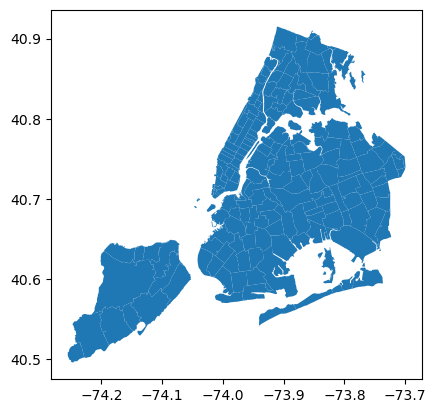

In [10]:
# Using the function
zipcode_datafile = ZIPCODE_DATA_FILE
cleaned_gdf = load_and_clean_zipcodes(zipcode_datafile)
print(cleaned_gdf.head())
cleaned_gdf.plot()

## Complaints Data

### `clean_and_save_311_file`
Cleans and saves a single 311 dataset GeoJSON file. Steps include file validation, data loading, column normalization, spatial join with NYC zip codes, and saving the cleaned data.

### `load_and_clean_311_data`
Processes a list of 311 data files using `clean_and_save_311_file`, streamlining the cleaning and saving process for multiple files.

In [11]:
def clean_and_save_311_file(file_path, output_directory):
    """
    Clean a single GeoJSON file and save the cleaned data to the specified output directory.

    :param file_path: File path of the GeoJSON file to clean.
    :param output_directory: Directory to save the cleaned GeoJSON files.
    """
    # Construct the output file path
    output_file_path = os.path.join(output_directory, os.path.basename(file_path))

    # Check if the output file already exists
    if os.path.exists(output_file_path):
        logging.warning(f"Output file already exists: {output_file_path}")
        return

    # Check if the file exists
    if not os.path.exists(file_path):
        logging.error(f"File does not exist: {file_path}")
        return

    # Log the processing of the file
    logging.info(f"Processing file: {file_path}")

    # Create the output directory if it does not exist
    Path(output_directory).mkdir(parents=True, exist_ok=True)

    # Load the GeoJSON file
    gdf = gpd.read_file(file_path)

    # Perform cleaning operations
    # Load and clean NYC zipcode data
    nyc_zipcodes_gdf = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)

    # Clean and preprocess 311 data
    columns_needed = ['unique_key', 'created_date', 'complaint_type', 'incident_zip', 'geometry']
    gdf = gdf[columns_needed]

    # Remove duplicates
    gdf.drop_duplicates(inplace=True)

    # Rename column 'incident_zip' to 'zipcode'
    gdf.rename(columns={'incident_zip': 'zipcode'}, inplace=True)

    # Normalize column names & column types
    gdf.columns = [col.lower().replace(' ', '_') for col in gdf.columns]
    gdf['unique_key'] = gdf['unique_key'].astype(str)
    gdf['created_date'] = pd.to_datetime(gdf['created_date'], errors='coerce').dropna()
    gdf['zipcode'] = gdf['zipcode'].astype(str)

    # Normalize the Spatial Reference Identifier (SRID) of the geometry
    gdf.set_crs(epsg=4326, inplace=True)

    # Ensure the 'zipcode' column in both dataframes is of the same type
    gdf['zipcode'] = gdf['zipcode'].astype(str)
    nyc_zipcodes_gdf['zipcode'] = nyc_zipcodes_gdf['zipcode'].astype(str)

    # Keep only data points whose zipcode exists in NYC zipcode dataframe
    gdf = gdf[gdf['zipcode'].isin(nyc_zipcodes_gdf['zipcode'])]
    gdf = gpd.sjoin(gdf, nyc_zipcodes_gdf, how='inner', predicate='intersects')
    
    # Merge 'zipcode_left' and 'zipcode_right' columns into a single 'zipcode' column
    gdf['zipcode'] = gdf['zipcode_left'].fillna(gdf['zipcode_right']).astype(str)
    
    # Drop the 'zipcode_left' and 'zipcode_right' columns
    gdf.drop(['zipcode_left', 'zipcode_right'], axis=1, inplace=True)
    
    # Drop the 'index_right' column
    gdf.drop(['index_right'], axis=1, inplace=True)

    # Save the cleaned GeoDataFrame as a new GeoJSON file
    gdf.to_file(output_file_path, driver='GeoJSON')

    # Log completion message
    logging.info(f"File processed and saved to: {output_file_path}")


In [12]:
def load_and_clean_311_data(file_list, output_directory):
    """
    Process each file in the file list: clean and save to the specified output directory.

    :param file_list: List of file paths of GeoJSON files to process.
    :param output_directory: Directory to save the cleaned GeoJSON files.
    """
    for file_path in file_list:
        clean_and_save_311_file(file_path, output_directory)


In [13]:
load_and_clean_311_data(file_list_311, 'data/cleaned_resource')

## Tree Data

### `clean_and_save_tree_data`
Cleans a single tree data file by removing non-NYC entries, duplicate tree IDs, and saves the cleaned data. Involves file verification, data loading, necessary column filtering, spatial join with NYC zip codes, duplicate removal, and saving the cleaned data.

### `load_and_clean_tree_data`
Processes multiple tree data files, applying `clean_and_save_tree_data` to each file for efficient batch cleaning and saving.

In [14]:
def clean_and_save_tree_data(file_path, output_directory):
    """
    Clean a single tree data file, remove entries not in NYC, remove duplicate tree_ids, and save the cleaned data to the specified output directory.

    :param file_path: File path of the tree data file to clean.
    :param output_directory: Directory to save the cleaned tree data files.
    """
    # Construct the output file path
    output_file_path = os.path.join(output_directory, os.path.basename(file_path))

    # Check if the output file already exists
    if os.path.exists(output_file_path):
        logging.warning(f"Output file already exists: {output_file_path}")
        return

    # Check if the file exists
    if not os.path.exists(file_path):
        logging.error(f"File does not exist: {file_path}")
        return

    # Log the processing of the file
    logging.info(f"Processing file: {file_path}")

    # Create the output directory if it does not exist
    Path(output_directory).mkdir(parents=True, exist_ok=True)

    # Load the tree data file
    gdf = gpd.read_file(file_path)

    # Perform cleaning operations
    columns_needed = ['tree_id', 'zipcode', 'spc_common', 'health', 'status', 'geometry']
    gdf = gdf[columns_needed]

    # Removing invalid data points
    gdf.dropna(subset=['zipcode', 'health', 'status'], inplace=True)

    # Rename 'spc_common' column to 'species'
    gdf.rename(columns={'spc_common': 'species'}, inplace=True)

    # Normalize column names & column types
    gdf.columns = [col.lower().replace(' ', '_') for col in gdf.columns]
    gdf['tree_id'] = gdf['tree_id'].astype(str)
    gdf['zipcode'] = gdf['zipcode'].astype(str)

    # Normalize the Spatial Reference Identifier (SRID) of the geometry
    gdf.set_crs(epsg=4326, inplace=True)

    # Load and clean NYC zipcode data
    nyc_zipcodes_gdf = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)

    # Filter out data points not in NYC
    gdf = gdf[gdf['zipcode'].isin(nyc_zipcodes_gdf['zipcode'])]
    gdf = gpd.sjoin(gdf, nyc_zipcodes_gdf, how='inner', predicate='intersects')
    
    # Merge 'zipcode_left' and 'zipcode_right' columns into a single 'zipcode' column
    gdf['zipcode'] = gdf['zipcode_left'].fillna(gdf['zipcode_right']).astype(str)
    
    # Drop the 'zipcode_left' and 'zipcode_right' columns
    gdf.drop(['zipcode_left', 'zipcode_right'], axis=1, inplace=True)
    
    # Drop the 'index_right' column
    gdf.drop(['index_right'], axis=1, inplace=True)
    
    # Remove duplicates based on tree_id
    gdf.drop_duplicates(subset=['tree_id'], inplace=True)

    # Save the cleaned GeoDataFrame as a new file
    gdf.to_file(output_file_path, driver='GeoJSON')

    # Log completion message
    logging.info(f"File processed and saved to: {output_file_path}")

In [15]:
def load_and_clean_tree_data(file_list, output_directory):
    """
    Process each file in the file list: clean and save to the specified output directory.

    :param file_list: List of file paths of GeoJSON files to process.
    :param output_directory: Directory to save the cleaned GeoJSON files.
    """
    for file_path in file_list:
        clean_and_save_tree_data(file_path, output_directory)


In [16]:
output_directory = 'data/cleaned_resource'
load_and_clean_tree_data(file_list_2015, output_directory)

## Zillow Data

This function is designed to load and clean Zillow rent data, specifically focusing on New York City zip codes. 

In [17]:
def load_and_clean_zillow_data(zillow_datafile):
    """
    Load and clean Zillow rent data, filter for NYC zip codes.

    Args:
        zillow_datafile (str): Path to the Zillow rent data CSV file.

    Returns:
        df (pd.DataFrame): Cleaned and filtered DataFrame containing Zillow rent data for NYC.
    """
    # Load Zillow rent data into a DataFrame
    df = pd.read_csv(zillow_datafile)
    
    # Filter to keep only NYC zip codes
    nyc_zipcodes_gdf = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    nyc_zipcodes_gdf['zipcode'] = nyc_zipcodes_gdf['zipcode'].astype(str)
    df['RegionName'] = df['RegionName'].astype(str)
    df = df[df['RegionName'].isin(nyc_zipcodes_gdf['zipcode'].astype(str))]

    # Define columns needed (RegionName and dates columns)
    columns_needed = ['RegionName'] + list(df.columns[10:])  # Select columns from 2015/1/31 onwards

    # Keep only the necessary columns
    df = df[columns_needed]

    # Rename 'RegionName' to 'zipcode'
    df.rename(columns={'RegionName': 'zipcode'}, inplace=True)

    # Normalize column names to lowercase
    df.columns = [col.lower() for col in df.columns]

    # Melt the DataFrame to have a structured format (Date, Zipcode, Value)
    df = df.melt(id_vars=['zipcode'], var_name='date', value_name='value')

    # Convert the 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    
    # Remove rows where 'value' is missing
    df = df.dropna(subset=['value'])

    # Reset the index
    df.reset_index(drop=True, inplace=True)
    
    return df


In [18]:
zillow_datafile = ZILLOW_DATA_FILE
cleaned_df_zillow = load_and_clean_zillow_data(zillow_datafile)
print(cleaned_df_zillow.head())

  zipcode       date        value
0   11385 2015-02-28  2087.527084
1   11226 2015-02-28  1971.608676
2   10025 2015-02-28  3075.667915
3   11206 2015-02-28  2482.958545
4   11221 2015-02-28  2138.483563


## Data Loading and Preprocessing

In [19]:
# Function to load all required data for the project.
def load_all_data():
    """
    This function loads and cleans various datasets required for the project.

    It loads zip code data, tree data, 311 data, and Zillow data.

    Returns:
    tuple: A tuple containing four dataframes -
           (geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data)
    """
    logger.info("Starting to load data...")

    # Load and clean zip code data
    geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    logger.info("Zip code data loaded successfully.")

    # Load and merge tree data
    geodf_tree_data_list = []
    for j in range(7):
        try:
            file_path = f"data/cleaned_resource/5rq2-4hqu.geojson_{j}.geojson"
            geodf_tree_data = gpd.read_file(file_path)
            geodf_tree_data_list.append(geodf_tree_data)
            logger.info(f"File loaded: {file_path}")
        except Exception as e:
            logger.error(f"Error reading file {file_path}: {e}")

    geodf_tree_data_j = pd.concat(geodf_tree_data_list, ignore_index=True)
    logger.info("Tree data loaded and merged successfully.")

    # Load and merge 311 data
    geodf_311_data_list = []
    for i in range(250):
        try:
            file_path = f"data/cleaned_resource/erm2-nwe9.geojson_{i}.geojson"
            geodf_311_data = gpd.read_file(file_path)
            geodf_311_data_list.append(geodf_311_data)
            logger.info(f"File loaded: {file_path}")
        except Exception as e:
            logger.error(f"Error reading file {file_path}: {e}")

    geodf_311_data_i = pd.concat(geodf_311_data_list, ignore_index=True)
    logger.info("311 data loaded and merged successfully.")

    # Load and clean Zillow data
    df_zillow_data = load_and_clean_zillow_data(ZILLOW_DATA_FILE)
    logger.info("Zillow data loaded successfully.")

    return (
        geodf_zipcode_data,
        geodf_311_data_i,
        geodf_tree_data_j,
        df_zillow_data
    )


In [21]:
# Load and preprocess all required data for the project
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

INFO:__main__:Starting to load data...
INFO:__main__:Zip code data loaded successfully.
INFO:__main__:File loaded: data/cleaned_resource/5rq2-4hqu.geojson_0.geojson
INFO:__main__:File loaded: data/cleaned_resource/5rq2-4hqu.geojson_1.geojson
INFO:__main__:File loaded: data/cleaned_resource/5rq2-4hqu.geojson_2.geojson
INFO:__main__:File loaded: data/cleaned_resource/5rq2-4hqu.geojson_3.geojson
INFO:__main__:File loaded: data/cleaned_resource/5rq2-4hqu.geojson_4.geojson
INFO:__main__:File loaded: data/cleaned_resource/5rq2-4hqu.geojson_5.geojson
INFO:__main__:File loaded: data/cleaned_resource/5rq2-4hqu.geojson_6.geojson
INFO:__main__:Tree data loaded and merged successfully.
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_0.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_1.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_2.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_3.geojson
INFO:__ma

INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_97.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_98.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_99.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_100.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_101.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_102.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_103.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_104.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_105.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_106.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_107.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_108.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-n

INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_201.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_202.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_203.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_204.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_205.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_206.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_207.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_208.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_209.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_210.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_211.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm2-nwe9.geojson_212.geojson
INFO:__main__:File loaded: data/cleaned_resource/erm

## Display DataFrame Information and First 5 Entries

In this code block, we intend to provide an overview of the data in different DataFrames. The code uses the `info()` method to display basic information about each DataFrame, including the data types and non-null counts of columns. Additionally, the `head()` method is used to display the first 5 entries (rows) of each DataFrame, giving a glimpse of the actual data.

In [22]:
# Show basic info about each dataframe
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   248 non-null    object  
 1   geometry  248 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 4.0+ KB


In [23]:
# Show first 5 entries about each dataframe
geodf_zipcode_data.head()

,zipcode,geometry
0,00083,"POLYGON ((-73.94922 40.79691, -73.94932 40.796..."
1,10001,"POLYGON ((-74.00827 40.75259, -74.00819 40.752..."
2,10002,"POLYGON ((-73.97442 40.73642, -73.97445 40.736..."
3,10003,"POLYGON ((-73.97986 40.73497, -73.98028 40.734..."
4,10004,"MULTIPOLYGON (((-74.02432 40.68392, -74.02436 ..."


In [24]:
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 23586301 entries, 0 to 23586300
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   unique_key      object        
 1   created_date    datetime64[ns]
 2   complaint_type  object        
 3   zipcode         object        
 4   geometry        geometry      
dtypes: datetime64[ns](1), geometry(1), object(3)
memory usage: 899.7+ MB


In [25]:
geodf_311_data.head()

,unique_key,created_date,complaint_type,zipcode,geometry
0,59576161,2023-11-29 12:00:00,Derelict Vehicles,11214,POINT (-73.99160 40.59598)
1,59576064,2023-11-29 01:01:43,Noise - Residential,11214,POINT (-74.00632 40.60849)
2,59563281,2023-11-29 00:31:34,Illegal Parking,11214,POINT (-73.99882 40.60958)
3,59581003,2023-11-28 23:58:42,Illegal Parking,11214,POINT (-73.99885 40.60960)
4,59579449,2023-11-28 23:56:18,Illegal Parking,11214,POINT (-73.98537 40.58698)


In [26]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 652137 entries, 0 to 652136
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   tree_id   652137 non-null  object  
 1   species   652132 non-null  object  
 2   health    652137 non-null  object  
 3   status    652137 non-null  object  
 4   zipcode   652137 non-null  object  
 5   geometry  652137 non-null  geometry
dtypes: geometry(1), object(5)
memory usage: 29.9+ MB


In [27]:
geodf_tree_data.head()

,tree_id,species,health,status,zipcode,geometry
0,180683,red maple,Fair,Alive,11375,POINT (-73.84422 40.72309)
1,203550,London planetree,Good,Alive,11375,POINT (-73.85445 40.71317)
2,193183,Amur maple,Good,Alive,11375,POINT (-73.83830 40.71703)
3,203577,London planetree,Good,Alive,11375,POINT (-73.85502 40.71248)
4,203386,London planetree,Good,Alive,11375,POINT (-73.85214 40.71264)


In [28]:
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8987 entries, 0 to 8986
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   zipcode  8987 non-null   object        
 1   date     8987 non-null   datetime64[ns]
 2   value    8987 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 210.8+ KB


In [29]:
df_zillow_data.head()

,zipcode,date,value
0,11385,2015-02-28,2087.527084
1,11226,2015-02-28,1971.608676
2,10025,2015-02-28,3075.667915
3,11206,2015-02-28,2482.958545
4,11221,2015-02-28,2138.483563


---

# Part 2: Storing Data

In Part 2 of the project, the focus shifts to storing the datasets obtained and cleaned in Part 1. The primary objective is to populate a PostgreSQL database with tables generated from these datasets.

In [31]:
!createdb group19project

createdb: error: database creation failed: ERROR:  database "group19project" already exists


In [32]:
!psql --dbname group19project -c 'CREATE EXTENSION postgis;'

CREATE EXTENSION


In [33]:
# Create a PostgreSQL engine
engine = create_engine("postgresql+psycopg2://joyliu@localhost/group19project")

In [34]:
from sqlalchemy import MetaData
from sqlalchemy.orm import declarative_base

# Create a metadata object
metadata = MetaData()

# Define the declarative base class using the updated import path
Base = declarative_base(metadata=metadata)


## Database Table Definitions

In this section, we define the structure and relationships of database tables that will be used for storing and organizing data related to zip codes, complaints, trees, and rent history. These tables are crucial for the analysis and management of diverse datasets in the project.

### ZipCode Table

The **ZipCode** table represents geographical information about zip codes. It includes the following fields:

- **zipcode**: The primary key, representing the zip code.
- **geometry**: A multi-polygon geometry associated with the zip code.

This table establishes key relationships with other tables:
- **complaints**: A one-to-many relationship with the 'Complaint' table.
- **trees**: A one-to-many relationship with the 'Tree' table.
- **rent_history**: A one-to-many relationship with the 'RentHistory' table.

### Complaint Table

The **Complaint** table represents records of complaints, including details about their creation and location. Key fields include:

- **id**: The primary key representing the complaint ID.
- **created_date**: The date when the complaint was created.
- **complaint_type**: The type of complaint (assumed to reference another table).
- **zipcode**: A foreign key referencing the 'ZipCode' table for zip code information.
- **geometry**: A point geometry associated with the complaint location.

This table establishes a many-to-one relationship with the 'ZipCode' table.

### Tree Table

The **Tree** table stores information about trees, including their species, health status, and location. Essential fields include:

- **tree_id**: The primary key representing the tree ID.
- **zipcode**: A foreign key referencing the 'ZipCode' table for zip code information.
- **species**: The species of the tree.
- **health**: The health status of the tree.
- **status**: The status of the tree.
- **geometry**: A point geometry associated with the tree location.

This table also establishes a many-to-one relationship with the 'ZipCode' table.

### RentHistory Table

The **RentHistory** table records historical data related to rent values. It contains the following fields:

- **id**: The primary key representing the rent history record ID.
- **zipcode**: A foreign key referencing the 'ZipCode' table for zip code information.
- **date**: The date associated with the rent history record.
- **value**: The rent value.

Similar to other tables, the 'RentHistory' table establishes a many-to-one relationship with the 'ZipCode' table.

In [35]:
# Define the ZipCode class to map to the 'zip_codes' table in the database
class ZipCode(Base):
    __tablename__ = 'zip_codes'
    __table_args__ = {'extend_existing': True}
    zipcode = Column(String(5), primary_key=True)  
    geometry = Column(Geometry('MULTIPOLYGON', srid=4326))
    
    # Define relationships with other tables
    complaints = relationship('Complaint', back_populates='zip_code')
    trees = relationship('Tree', back_populates='zip_code')
    rent_history = relationship('RentHistory', back_populates='zip_code')

# Define the Complaint class to map to the 'complaints' table in the database
class Complaint(Base):
    __tablename__ = 'complaints'
    __table_args__ = {'extend_existing': True}
    
    id = Column(Integer, primary_key=True)
    created_date = Column(DateTime)
    complaint_type = Column(String)  # Assuming this column references another table
    zipcode = Column(String(5), ForeignKey('zip_codes.zipcode'))  # Reference the 'zipcode' column
    geometry = Column(Geometry('POINT', srid=4326))
    
    # Define many-to-one relationship with ZipCode table
    zip_code = relationship('ZipCode', back_populates='complaints')

# Define the Tree class to map to the 'trees' table in the database
class Tree(Base):
    __tablename__ = 'trees'
    __table_args__ = {'extend_existing': True}
    tree_id = Column(Integer, primary_key=True)
    zipcode = Column(String(5), ForeignKey('zip_codes.zipcode'))  # Reference the 'zipcode' column
    species = Column(String)
    health = Column(String)
    status = Column(String)
    geometry = Column(Geometry('POINT', srid=4326))
    
    # Define many-to-one relationship with ZipCode table
    zip_code = relationship('ZipCode', back_populates='trees')

# Define the RentHistory class to map to the 'rent_history' table in the database
class RentHistory(Base):
    __tablename__ = 'rent_history'
    __table_args__ = {'extend_existing': True}
    id = Column(Integer, primary_key=True)
    zipcode = Column(String(5), ForeignKey('zip_codes.zipcode'))  # Reference the 'zipcode' column
    date = Column(DateTime)
    value = Column(Float)
    
    # Define many-to-one relationship with ZipCode table
    zip_code = relationship('ZipCode', back_populates='rent_history')

In [36]:
# Create the tables in the database
Base.metadata.create_all(engine)

## Generate SQL Schema File

This code generates an SQL schema file ('schema.sql') that contains the CREATE TABLE statements for all tables defined in the database metadata and uses the SQLAlchemy library.



In [37]:
with open('schema.sql', 'w') as schema_file:
    for table in metadata.sorted_tables:
        # Compile the CREATE TABLE statement for the current table using the SQLAlchemy dialect
        create_statement = CreateTable(table).compile(dialect=engine.dialect)
        
        # Write the CREATE TABLE statement to the schema file with a semicolon and newline
        schema_file.write(str(create_statement) + ';\n')

# Print a confirmation message
print("Schema file 'schema.sql' has been generated.")


Schema file 'schema.sql' has been generated.


## insert_data Function

The `insert_data` function is responsible for inserting data into a PostgreSQL database table. It accepts the following parameters:

- `cursor`: The database cursor for executing SQL commands.
- `table_name`: The name of the target table in the database.
- `data`: A dictionary containing the data to be inserted.
- `connection`: The database connection.

The function constructs and executes an SQL INSERT statement based on the provided parameters. In case of an error during insertion, it prints detailed error information, including the error message and code. The transaction is rolled back to maintain data integrity.

In [38]:
# Define the insert_data function
def insert_data(cursor, table_name, data, connection):
    """
    Inserts data into a PostgreSQL database table, handling potential errors.
    
    This function constructs and executes an SQL INSERT statement for a specified table in the PostgreSQL database.
    It accepts the cursor, target table name, data dictionary, and connection as parameters.
    
    In case of an error, detailed error information is printed, including the error message and code.
    The transaction is rolled back to maintain data integrity.
    """

    try:
        columns = ', '.join(data.keys())
        placeholders = ', '.join(['%s' for _ in data])
        sql = f"INSERT INTO {table_name} ({columns}) VALUES ({placeholders})"
        cursor.execute(sql, tuple(data.values()))
    except psycopg2.Error as e:
        print("Error inserting data:", e)
        print("Error details:", e.pgerror)  # Print detailed error information
        print("Error code:", e.pgcode)     # Print error code
        connection.rollback()  # Rollback the transaction

In [39]:
# Establish a database connection
conn = psycopg2.connect(dbname="group19project", user="joyliu", host="localhost", port=5432)
cursor = conn.cursor()

### Inserting Geospatial Data

This code block processes geospatial data from `geodf_zipcode_data` and inserts it into the 'zip_codes' table in the database. It iterates through the rows, converting geometry to GeoJSON format, and handles progress logging. In case of a database error, it rolls back the transaction.



In [40]:
def is_data_inserted(session, model, **kwargs):
    """
    Check if data already exists in the database based on the provided model and filter conditions.
    
    :param session: SQLAlchemy session object
    :param model: SQLAlchemy model class
    :param kwargs: Filter conditions as keyword arguments (e.g., zipcode='12345')
    :return: True if data exists, False otherwise
    """
    try:
        # Use the provided filter conditions to query the database
        existing_data = session.query(model).filter_by(**kwargs).first()
        return existing_data is not None
    except sqlalchemy.exc.SQLAlchemyError as e:
        print("Database error:", e)
        session.rollback()
        return False

In [41]:
try:
    Session = sessionmaker(bind=engine)
    session = Session()
    # Process geodf_zipcode_data
    for index, row in geodf_zipcode_data.iterrows():
        # Check if the data is already inserted based on some condition (e.g., zipcode)
        if not is_data_inserted(session, ZipCode, zipcode=row['zipcode']):
            geom_geojson = json.dumps(mapping(row['geometry'])) if row['geometry'] else None
            data = {
                'zipcode': row['zipcode'],
                'geometry': geom_geojson
            }
            insert_data(cursor, 'zip_codes', data, conn)

            # Log progress for each row or at specific intervals
            if (index + 1) % 100 == 0 or (index + 1) == geodf_zipcode_data.shape[0]:
                logging.info(f"Inserted ZipCode row {index + 1} of {geodf_zipcode_data.shape[0]}")
        else:
            pass
        
    conn.commit()

except psycopg2.Error as e:
    print("Database error:", e)
    conn.rollback()

INFO:root:Inserted ZipCode row 100 of 248
INFO:root:Inserted ZipCode row 200 of 248
INFO:root:Inserted ZipCode row 248 of 248


### Inserting Zillow Rent Data

This code block processes data from `df_zillow_data` and inserts it into the 'rent_history' table in the database. It logs progress at specified intervals or for the last row and handles database errors by rolling back the transaction.

In [42]:
try:
    # Create a session
    Session = sessionmaker(bind=engine)
    session = Session()

    # Process df_zillow_data
    for index, row in df_zillow_data.iterrows():
        # Check if the data is already inserted based on some condition (e.g., zipcode and date)
        if not is_data_inserted(session, RentHistory, zipcode=row['zipcode'], date=row['date']):
            data = {
                'zipcode': row['zipcode'],
                'date': row['date'],
                'value': row['value']
            }
            insert_data(cursor, 'rent_history', data, conn)

            # Log progress at specific intervals or for the last row
            if (index + 1) % 1000 == 0 or (index + 1) == df_zillow_data.shape[0]:
                logging.info(f"Inserted Rent row {index + 1} of {df_zillow_data.shape[0]}")
        else:
            pass

    conn.commit()

except psycopg2.Error as e:
    print("Database error:", e)
    conn.rollback()

INFO:root:Inserted Rent row 1000 of 8987
INFO:root:Inserted Rent row 2000 of 8987
INFO:root:Inserted Rent row 3000 of 8987
INFO:root:Inserted Rent row 4000 of 8987
INFO:root:Inserted Rent row 5000 of 8987
INFO:root:Inserted Rent row 6000 of 8987
INFO:root:Inserted Rent row 7000 of 8987
INFO:root:Inserted Rent row 8000 of 8987
INFO:root:Inserted Rent row 8987 of 8987


### Inserting Tree Data

This code processes data from `geodf_tree_data` and inserts it into the 'trees' table in the database. It logs progress at specific intervals or for the last row and handles database errors by rolling back the transaction.


In [43]:
try:
    # Create a session for database operations
    Session = sessionmaker(bind=engine)
    session = Session()

    # Process geodf_tree_data
    for index, row in geodf_tree_data.iterrows():
        # Check if the tree data is already inserted based on some condition (e.g., tree_id)
        if not is_data_inserted(session, Tree, tree_id=row['tree_id']):
            # Prepare geometry data in GeoJSON format if available
            geom_geojson = json.dumps(mapping(row['geometry'])) if row['geometry'] else None
            
            # Create a dictionary for the tree data
            data = {
                'tree_id': row['tree_id'],
                'zipcode': row['zipcode'],
                'species': row['species'],
                'health': row['health'],
                'status': row['status'],
                'geometry': geom_geojson
            }
            
            # Insert data into the 'trees' table
            insert_data(cursor, 'trees', data, conn)

            # Log progress at specific intervals or for the last row
            if (index + 1) % 1000 == 0 or (index + 1) == geodf_tree_data.shape[0]:
                logging.info(f"Inserted Tree row {index + 1} of {geodf_tree_data.shape[0]}")
        else:
            pass

    # Commit the transaction if all data is processed successfully
    conn.commit()

except psycopg2.Error as e:
    # Log database errors and rollback the transaction
    logging.error("Database error:", e)
    conn.rollback()


INFO:root:Inserted Tree row 1000 of 652137
INFO:root:Inserted Tree row 2000 of 652137
INFO:root:Inserted Tree row 3000 of 652137
INFO:root:Inserted Tree row 4000 of 652137
INFO:root:Inserted Tree row 5000 of 652137
INFO:root:Inserted Tree row 6000 of 652137
INFO:root:Inserted Tree row 7000 of 652137
INFO:root:Inserted Tree row 8000 of 652137
INFO:root:Inserted Tree row 9000 of 652137
INFO:root:Inserted Tree row 10000 of 652137
INFO:root:Inserted Tree row 11000 of 652137
INFO:root:Inserted Tree row 12000 of 652137
INFO:root:Inserted Tree row 13000 of 652137
INFO:root:Inserted Tree row 14000 of 652137
INFO:root:Inserted Tree row 15000 of 652137
INFO:root:Inserted Tree row 16000 of 652137
INFO:root:Inserted Tree row 17000 of 652137
INFO:root:Inserted Tree row 18000 of 652137
INFO:root:Inserted Tree row 19000 of 652137
INFO:root:Inserted Tree row 20000 of 652137
INFO:root:Inserted Tree row 21000 of 652137
INFO:root:Inserted Tree row 22000 of 652137
INFO:root:Inserted Tree row 23000 of 6521

INFO:root:Inserted Tree row 186000 of 652137
INFO:root:Inserted Tree row 187000 of 652137
INFO:root:Inserted Tree row 188000 of 652137
INFO:root:Inserted Tree row 189000 of 652137
INFO:root:Inserted Tree row 190000 of 652137
INFO:root:Inserted Tree row 191000 of 652137
INFO:root:Inserted Tree row 192000 of 652137
INFO:root:Inserted Tree row 193000 of 652137
INFO:root:Inserted Tree row 194000 of 652137
INFO:root:Inserted Tree row 195000 of 652137
INFO:root:Inserted Tree row 196000 of 652137
INFO:root:Inserted Tree row 197000 of 652137
INFO:root:Inserted Tree row 198000 of 652137
INFO:root:Inserted Tree row 199000 of 652137
INFO:root:Inserted Tree row 200000 of 652137
INFO:root:Inserted Tree row 201000 of 652137
INFO:root:Inserted Tree row 202000 of 652137
INFO:root:Inserted Tree row 203000 of 652137
INFO:root:Inserted Tree row 204000 of 652137
INFO:root:Inserted Tree row 205000 of 652137
INFO:root:Inserted Tree row 206000 of 652137
INFO:root:Inserted Tree row 207000 of 652137
INFO:root:

INFO:root:Inserted Tree row 369000 of 652137
INFO:root:Inserted Tree row 370000 of 652137
INFO:root:Inserted Tree row 371000 of 652137
INFO:root:Inserted Tree row 372000 of 652137
INFO:root:Inserted Tree row 373000 of 652137
INFO:root:Inserted Tree row 374000 of 652137
INFO:root:Inserted Tree row 375000 of 652137
INFO:root:Inserted Tree row 376000 of 652137
INFO:root:Inserted Tree row 377000 of 652137
INFO:root:Inserted Tree row 378000 of 652137
INFO:root:Inserted Tree row 379000 of 652137
INFO:root:Inserted Tree row 380000 of 652137
INFO:root:Inserted Tree row 381000 of 652137
INFO:root:Inserted Tree row 382000 of 652137
INFO:root:Inserted Tree row 383000 of 652137
INFO:root:Inserted Tree row 384000 of 652137
INFO:root:Inserted Tree row 385000 of 652137
INFO:root:Inserted Tree row 386000 of 652137
INFO:root:Inserted Tree row 387000 of 652137
INFO:root:Inserted Tree row 388000 of 652137
INFO:root:Inserted Tree row 389000 of 652137
INFO:root:Inserted Tree row 390000 of 652137
INFO:root:

INFO:root:Inserted Tree row 552000 of 652137
INFO:root:Inserted Tree row 553000 of 652137
INFO:root:Inserted Tree row 554000 of 652137
INFO:root:Inserted Tree row 555000 of 652137
INFO:root:Inserted Tree row 556000 of 652137
INFO:root:Inserted Tree row 557000 of 652137
INFO:root:Inserted Tree row 558000 of 652137
INFO:root:Inserted Tree row 559000 of 652137
INFO:root:Inserted Tree row 560000 of 652137
INFO:root:Inserted Tree row 561000 of 652137
INFO:root:Inserted Tree row 562000 of 652137
INFO:root:Inserted Tree row 563000 of 652137
INFO:root:Inserted Tree row 564000 of 652137
INFO:root:Inserted Tree row 565000 of 652137
INFO:root:Inserted Tree row 566000 of 652137
INFO:root:Inserted Tree row 567000 of 652137
INFO:root:Inserted Tree row 568000 of 652137
INFO:root:Inserted Tree row 569000 of 652137
INFO:root:Inserted Tree row 570000 of 652137
INFO:root:Inserted Tree row 571000 of 652137
INFO:root:Inserted Tree row 572000 of 652137
INFO:root:Inserted Tree row 573000 of 652137
INFO:root:

### Inserting 311 Complaint Data

This code processes data from `geodf_311_data` and inserts it into the 'complaints' table in the database. It logs progress for each row or at specific intervals and commits the changes after processing the data. In case of a database error, it rolls back the transaction.


In [44]:
try:
    # Process geodf_311_data
    for index, row in geodf_311_data.iterrows():
        geom_geojson = json.dumps(mapping(row['geometry'])) if row['geometry'] else None
        data = {
            'created_date': row['created_date'].isoformat() if pd.notnull(row['created_date']) else None,
            'complaint_type': row['complaint_type'],
            'zipcode': row['zipcode'],
            'geometry': geom_geojson
        }
        insert_data(cursor, 'complaints', data, conn)

        # Log progress for each row or at specific intervals
        if (index + 1) % 100000 == 0 or (index + 1) == geodf_311_data.shape[0]:
            logging.info(f"Inserted Complaint row {index + 1} of {geodf_311_data.shape[0]}")

    # Commit the changes after processing geodf_311_data
    conn.commit()

except psycopg2.Error as e:
    print("Database error:", e)
    conn.rollback()

INFO:root:Inserted Complaint row 100000 of 23586301
INFO:root:Inserted Complaint row 200000 of 23586301
INFO:root:Inserted Complaint row 300000 of 23586301
INFO:root:Inserted Complaint row 400000 of 23586301
INFO:root:Inserted Complaint row 500000 of 23586301
INFO:root:Inserted Complaint row 600000 of 23586301
INFO:root:Inserted Complaint row 700000 of 23586301
INFO:root:Inserted Complaint row 800000 of 23586301
INFO:root:Inserted Complaint row 900000 of 23586301
INFO:root:Inserted Complaint row 1000000 of 23586301
INFO:root:Inserted Complaint row 1100000 of 23586301
INFO:root:Inserted Complaint row 1200000 of 23586301
INFO:root:Inserted Complaint row 1300000 of 23586301
INFO:root:Inserted Complaint row 1400000 of 23586301
INFO:root:Inserted Complaint row 1500000 of 23586301
INFO:root:Inserted Complaint row 1600000 of 23586301
INFO:root:Inserted Complaint row 1700000 of 23586301
INFO:root:Inserted Complaint row 1800000 of 23586301
INFO:root:Inserted Complaint row 1900000 of 23586301
IN

INFO:root:Inserted Complaint row 15500000 of 23586301
INFO:root:Inserted Complaint row 15600000 of 23586301
INFO:root:Inserted Complaint row 15700000 of 23586301
INFO:root:Inserted Complaint row 15800000 of 23586301
INFO:root:Inserted Complaint row 15900000 of 23586301
INFO:root:Inserted Complaint row 16000000 of 23586301
INFO:root:Inserted Complaint row 16100000 of 23586301
INFO:root:Inserted Complaint row 16200000 of 23586301
INFO:root:Inserted Complaint row 16300000 of 23586301
INFO:root:Inserted Complaint row 16400000 of 23586301
INFO:root:Inserted Complaint row 16500000 of 23586301
INFO:root:Inserted Complaint row 16600000 of 23586301
INFO:root:Inserted Complaint row 16700000 of 23586301
INFO:root:Inserted Complaint row 16800000 of 23586301
INFO:root:Inserted Complaint row 16900000 of 23586301
INFO:root:Inserted Complaint row 17000000 of 23586301
INFO:root:Inserted Complaint row 17100000 of 23586301
INFO:root:Inserted Complaint row 17200000 of 23586301
INFO:root:Inserted Complaint

In [45]:
# Closes the database connection
if conn is not None:
    cursor.close()
    conn.close()
    print("Data processing and insertion completed successfully. Database connection closed.")

Data processing and insertion completed successfully. Database connection closed.


---
# Part 3: Understanding Data

In this part, a series of SQL queries are crafted to gain insights into the datasets used for this project. Each query is designed to answer a specific question related to the data. The queries are saved as separate .sql files with descriptive names indicating their purpose.

In [46]:
# Helper function to write the queries to a file
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as file:
        file.write(query)

## Query 1: Identifying Calm Areas to Live

The purpose of this code block is to execute a SQL query to find the number of 311 complaints per zip code in New York City between October 1st, 2022, and September 30th, 2023, inclusive. The query results will be ordered by the number of complaints in descending order. The information can help identify areas that might be more calm to live in based on complaint counts.

In [47]:
QUERY_1_FILENAME = QUERY_DIR / "complaints_per_zipcode.sql"

# SQL Query
QUERY_1 = """
SELECT zipcode, COUNT(*) AS num_complaints
FROM complaints
WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY zipcode
ORDER BY num_complaints DESC;
"""

In [48]:
# Execute the query and store the results in a DataFrame
engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")
with engine.connect() as conn:
    result = conn.execute(text(QUERY_1))
    df1 = pd.DataFrame(result.fetchall(), columns=result.keys())

df1

,zipcode,num_complaints
0,11226,49112
1,10467,47214
2,10468,43926
3,10452,43706
4,11385,43460
...,...,...
226,10155,4
227,00083,2
228,10055,2
229,10080,1


In [49]:
# Write the query to a file
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

## Query 2: Identifying Areas with the Most Greenery

The purpose of this code block is to execute a SQL query to find the top 10 zip codes with the most trees in New York City, using data from the 'trees' table. The query results will be sorted by the total number of trees in descending order, helping to identify areas with the most greenery.

In [50]:
QUERY_2_FILENAME = QUERY_DIR / "top_10_zipcodes_by_trees.sql"

# SQL Query
QUERY_2 = """
SELECT zipcode, COUNT(*) AS num_trees
FROM trees
GROUP BY zipcode
ORDER BY num_trees DESC
LIMIT 10;
"""

In [51]:
# Execute the query and store the results in a DataFrame
engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")
with engine.connect() as conn:
    result = conn.execute(text(QUERY_2))
    df2 = pd.DataFrame(result.fetchall(), columns=result.keys())

df2

,zipcode,num_trees
0,10312,21356
1,10314,16330
2,10306,12616
3,10309,12105
4,11234,10838
5,11385,10262
6,11357,9017
7,11207,8293
8,11208,7896
9,11434,7833


In [52]:
# Write the query to a file
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

## Query 3: Affordability in Green Areas

The purpose of this code block is to execute a SQL query to determine the average rent for August 2023 in the top 10 zip codes with the most trees in New York City. This query involves a JOIN operation between the 'trees' and 'rent_history' tables. The results are formatted for readability, showing zip codes and average rents.

In [53]:
QUERY_3_FILENAME = QUERY_DIR / "average_rent_in_greenest_areas.sql"

# SQL Query
QUERY_3 = """
WITH TopTreeZipCodes AS (
    SELECT zipcode
    FROM trees
    GROUP BY zipcode
    ORDER BY COUNT(*) DESC
    LIMIT 10
)
SELECT r.zipcode, TO_CHAR(AVG(r.value), 'FM9,999,999.00') as average_rent
FROM rent_history r
INNER JOIN TopTreeZipCodes ttzc ON r.zipcode = ttzc.zipcode
WHERE DATE_PART('month', r.date) = 8 AND DATE_PART('year', r.date) = 2023
GROUP BY r.zipcode
ORDER BY AVG(r.value) DESC;
"""

In [54]:
# Execute the query and store the results in a DataFrame
engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")
with engine.connect() as conn:
    result = conn.execute(text(QUERY_3))
    df3 = pd.DataFrame(result.fetchall(), columns=result.keys())

df3

,zipcode,average_rent
0,11207,"3,079.09"
1,11385,"3,064.48"
2,11208,"2,737.55"
3,11434,"2,645.92"
4,10314,"2,465.47"
5,11357,"2,458.81"
6,10306,"2,331.54"
7,11234,"2,312.31"
8,10309,"1,832.01"
9,10312,"1,775.09"


In [55]:
# Write the query to a file
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

## Query 4: Rent, Trees, and Complaints Correlation

This code block executes a SQL query to explore potential correlations between average rent, the number of trees, and the number of 311 complaints for zip codes in New York City. Specifically, it retrieves data for the month of January 2023. It can help identify patterns and correlations that may inform urban planning decisions.


In [56]:
QUERY_4_FILENAME = QUERY_DIR / "rent_trees_complaints_correlation.sql"

# SQL Query
QUERY_4 = """
WITH RentData AS (
    SELECT zipcode, AVG(value) as average_rent
    FROM rent_history
    WHERE DATE_PART('month', date) = 1 AND DATE_PART('year', date) = 2023
    GROUP BY zipcode
),
RankedRent AS (
    SELECT zipcode, average_rent, 
           DENSE_RANK() OVER (ORDER BY average_rent DESC) as high_rank,
           DENSE_RANK() OVER (ORDER BY average_rent) as low_rank
    FROM RentData
)
SELECT r.zipcode, TO_CHAR(r.average_rent, 'FM9,999,999.00') as average_rent, 
       COUNT(t.tree_id) as tree_count, COUNT(c.id) as complaint_count
FROM RankedRent r
LEFT JOIN trees t ON r.zipcode = t.zipcode
LEFT JOIN complaints c ON r.zipcode = c.zipcode
WHERE r.high_rank <= 5 OR r.low_rank <= 5
GROUP BY r.zipcode, r.average_rent
ORDER BY r.average_rent DESC;
"""

In [57]:
# Execute the query and store the results in a DataFrame
engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")
with engine.connect() as conn:
    result = conn.execute(text(QUERY_4))
    df4 = pd.DataFrame(result.fetchall(), columns=result.keys())

df4

,zipcode,average_rent,tree_count,complaint_count
0,10007,"7,270.24",10873798,10873798
1,10282,"7,143.35",1057540,1057540
2,10013,"5,480.11",113347160,113347160
3,10069,"4,959.67",462336,462336
4,10011,"4,741.87",319557840,319557840
5,10458,"1,883.08",933609556,933609556
6,11357,"1,829.66",902394309,902394309
7,10453,"1,820.23",850201050,850201050
8,10462,"1,801.89",861001504,861001504
9,10309,"1,380.51",980383950,980383950


In [58]:
# Write the query to a file
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

## Query 5: Greenery Spatial Join

This code block performs a SQL query to determine the number of trees in each zip code area using a spatial join. It joins both the `trees` table and the `zipcodes` table, where the coordinate point of each tree is inside the polygon boundary of the zip code as defined in the `zipcodes` table. The query aims to obtain results that match the results of Query 2. This spatial join approach considers the geographical boundaries of zip codes and the locations of individual trees.


In [59]:
QUERY_5_FILENAME = QUERY_DIR / "greenery_spatial_join.sql"

# SQL Query
QUERY_5 = """
SELECT z.zipcode, COUNT(t.tree_id) as tree_count
FROM zip_codes z
JOIN trees t ON z.zipcode = t.zipcode
WHERE ST_Contains(z.geometry, t.geometry)
GROUP BY z.zipcode
ORDER BY tree_count DESC
LIMIT 10;
"""

In [60]:
# Execute the query and store the results in a DataFrame
engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")
with engine.connect() as conn:
    result = conn.execute(text(QUERY_5))
    df5 = pd.DataFrame(result.fetchall(), columns=result.keys())

df5

,zipcode,tree_count
0,10312,21356
1,10314,16330
2,10306,12616
3,10309,12105
4,11234,10838
5,11385,10262
6,11357,9017
7,11207,8293
8,11208,7896
9,11434,7833


In [61]:
# Write the query to a file
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

## Query 6: Trees Near Coordinate

This code block executes a SQL query to find trees within a ½ mile radius of a specific coordinate pair: Latitude 40.80737875669467 and Longitude -73.96253174434912. The query returns information about each tree, including its ID, species, health, status, and coordinate location.

In [62]:
QUERY_6_FILENAME = QUERY_DIR / "trees_near_coordinate.sql"

# SQL Query
QUERY_6 = """
SELECT t.tree_id, t.species, t.health, t.status, ST_AsText(t.geometry) as location
FROM trees t
WHERE ST_DWithin(
    t.geometry, 
    ST_GeomFromText('POINT(-73.96253174434912 40.80737875669467)', 4326),
    0.5 * 1609.34  -- 0.5 miles in meters
)
"""

In [63]:
# Execute the query and store the results in a DataFrame
engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")
with engine.connect() as conn:
    result = conn.execute(text(QUERY_6))
    df6 = pd.DataFrame(result.fetchall(), columns=result.keys())

df6

,tree_id,species,health,status,location
0,180683,red maple,Fair,Alive,POINT(-73.84421521958048 40.723091773924274)
1,203550,London planetree,Good,Alive,POINT(-73.85444599003124 40.71316968515154)
2,193183,Amur maple,Good,Alive,POINT(-73.83829721619878 40.7170323149707)
3,203577,London planetree,Good,Alive,POINT(-73.85501987714406 40.7124796096016)
4,203386,London planetree,Good,Alive,POINT(-73.85213797272486 40.71264110335946)
...,...,...,...,...,...
652132,188955,London planetree,Good,Alive,POINT(-73.97165956231974 40.67303749362568)
652133,189363,silver linden,Fair,Alive,POINT(-73.97287969597299 40.67681458969243)
652134,189625,Callery pear,Fair,Alive,POINT(-73.97513817328378 40.674786871208525)
652135,182748,pin oak,Good,Alive,POINT(-73.97871414042268 40.67884638919748)


In [64]:
# Write the query to a file
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

---
# Part 4: Visualizing Data
In Part 4, we focus on creating visualizations to gain insights and enhance our understanding of the datasets. These visualizations are generated using libraries like Matplotlib, Geopandas, and other visualization tools. Each visualization is designed to be self-explanatory, with labeled axes, titles, and appropriate visual elements.


## Visualization 1: Complaint Types Over Time

**Objective:** Visualize the top 3 complaint types in New York City between October 1st, 2022, and September 30th, 2023, and track the number of complaints per day for these types.

**Implementation:** 
1. We begin by querying the database to identify the top 3 complaint types during the specified timeframe.
2. Next, we retrieve the daily counts of complaints for each of these top complaint types.
3. Using Matplotlib, we create a line plot that illustrates the daily number of complaints over time for each of the top 3 complaint types.
4. The x-axis represents the date, and the y-axis represents the number of complaints.
5. Each complaint type is color-coded and labeled for clarity.
6. The resulting visualization provides insights into the most prevalent issues in the city and how they vary over time.

**Interpretation:** 
This visualization allows us to understand the frequency and patterns of the top 3 complaint types in NYC over the specified period. It can help city officials and residents monitor and address common concerns more effectively.


In [65]:
def visualize_top_3_complaints():
    engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")

    # Query to get top 3 complaint types
    top_complaints_query = """
    SELECT complaint_type, COUNT(*) as total_complaints
    FROM complaints
    WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY total_complaints DESC
    LIMIT 3
    """
    top_complaints_df = pd.read_sql(top_complaints_query, engine)

    # Query to get daily complaints for these types
    daily_complaints_query = """
    SELECT date_trunc('day', created_date) as date, complaint_type, COUNT(*) as daily_count
    FROM complaints
    WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
    AND complaint_type IN ('{}')
    GROUP BY date, complaint_type
    ORDER BY date
    """.format("', '".join(top_complaints_df['complaint_type'].tolist()))
    daily_complaints_df = pd.read_sql(daily_complaints_query, engine)

    # Plotting
    for complaint_type in daily_complaints_df['complaint_type'].unique():
        subset = daily_complaints_df[daily_complaints_df['complaint_type'] == complaint_type]
        plt.plot(subset['date'], subset['daily_count'], label=complaint_type)

    plt.xlabel('Date')
    plt.ylabel('Number of Complaints')
    plt.title('Top 3 Complaint Types in NYC')
    plt.legend()
    plt.show()

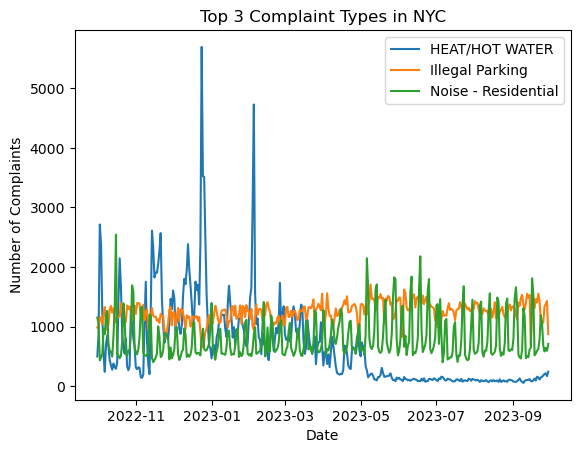

In [66]:
visualize_top_3_complaints()

## Visualization 2: Common Complaints in Zip Code 10027

**Objective:** Visualize the top 10 complaint types in Zip Code 10027 between October 1st, 2018, and September 30th, 2023.

**Implementation:** 
1. We use an SQL query to extract the top 10 complaint types from Zip Code 10027 within the specified timeframe.
2. The retrieved data is then plotted as a bar chart using Matplotlib.
3. The x-axis displays the complaint types, while the y-axis represents the number of complaints.
4. The visualization provides a clear overview of the most common complaints in this specific zip code.
5. To enhance readability, we rotate the x-axis labels.

**Interpretation:** 
This visualization helps us understand the most frequent issues reported in Zip Code 10027 over the specified period. It can be valuable for local authorities and residents in addressing and prioritizing neighborhood concerns.


In [67]:
def visualize_common_complaints_zip_10027():
    engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")

    # SQL query to get top 10 complaints in zip code 10027
    query = """
    SELECT complaint_type, COUNT(*) as complaint_count
    FROM complaints
    WHERE zipcode = '10027' AND created_date BETWEEN '2018-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY complaint_count DESC
    LIMIT 10
    """
    df = pd.read_sql(query, engine)

    # Plotting
    plt.figure(figsize=(10, 6))
    df.plot(kind='bar', x='complaint_type', y='complaint_count', legend=False, ax=plt.gca())
    plt.title('Top 10 Complaints in Zip Code 10027 (2018-2023)')
    plt.xlabel('Complaint Type')
    plt.ylabel('Number of Complaints')
    plt.xticks(rotation=60)  # Rotate labels
    plt.tight_layout()
    plt.show()

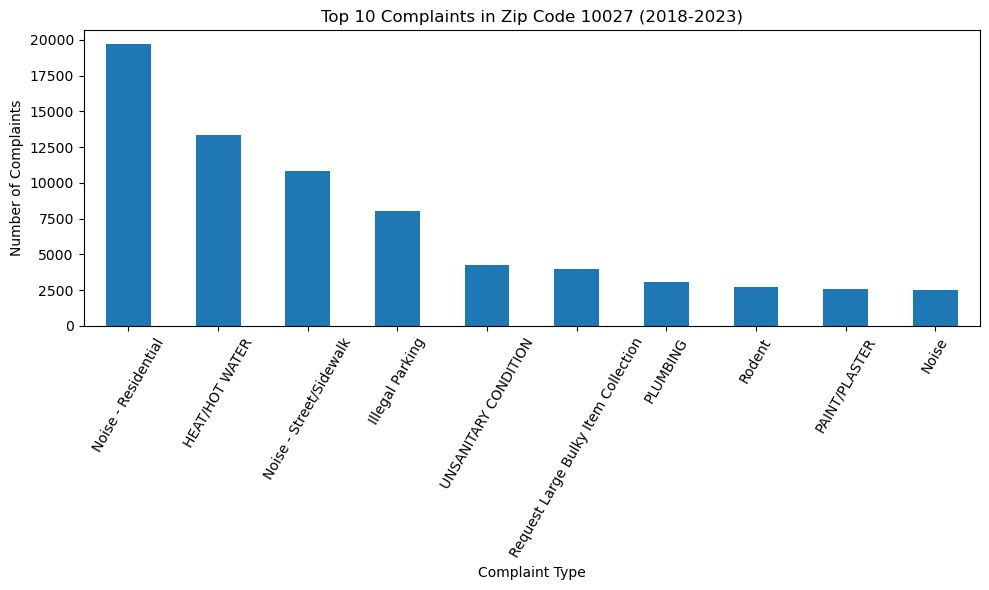

In [68]:
visualize_common_complaints_zip_10027()

## Visualization 3: Correlation Between Rent, Trees, and Complaints

**Objective:** Visualize the correlation between average rent, the number of trees, and the number of complaints by zip code from January 1st, 2015, to September 30th, 2023.

**Implementation:** 
1. We use an SQL query to retrieve data on average rent, the number of trees, and the number of complaints for each zip code within the specified timeframe.
2. The retrieved data is plotted using Matplotlib in two subplots:
   - The first subplot shows a scatter plot of average rent vs. the number of trees by zip code.
   - The second subplot displays a scatter plot of average rent vs. the number of complaints by zip code.
3. Both subplots share the x-axis, allowing for easy comparison.
4. This visualization helps explore potential correlations between these factors.

**Interpretation:** 
By examining the two scatter plots, we can gain insights into any potential relationships between rent, the presence of trees, and the number of complaints in different zip codes. This analysis can assist in understanding how these variables might be related and their implications for specific areas.


In [ ]:
query = """
    SELECT r.zipcode, AVG(r.value) as average_rent, 
           COUNT(DISTINCT t.tree_id) as tree_count, 
           COUNT(DISTINCT c.id) as complaint_count
    FROM rent_history r
    LEFT JOIN trees t ON r.zipcode = t.zipcode
    LEFT JOIN complaints c ON r.zipcode = c.zipcode
    WHERE r.date BETWEEN '2015-01-01' AND '2015-09-30'
    GROUP BY r.zipcode
    """
# Execute the query and store the results in a DataFrame
engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")
with engine.connect() as conn:
    result = conn.execute(text(query))
    df = pd.DataFrame(result.fetchall(), columns=result.keys())

df

In [ ]:
def visualize_rent_trees_complaints_correlation():
    engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")

    # SQL query to get rent, tree count, and complaint count by zip code
    query = """
    SELECT r.zipcode, AVG(r.value) as average_rent, 
           COUNT(DISTINCT t.tree_id) as tree_count, 
           COUNT(DISTINCT c.id) as complaint_count
    FROM rent_history r
    LEFT JOIN trees t ON r.zipcode = t.zipcode
    LEFT JOIN complaints c ON r.zipcode = c.zipcode
    WHERE r.date BETWEEN '2015-01-01' AND '2023-09-30'
    GROUP BY r.zipcode
    """
    df = pd.read_sql(query, engine)

    # Creating subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # First subplot: Rent vs. Number of Trees
    ax1.scatter(df['average_rent'], df['tree_count'])
    ax1.set_title('Rent vs. Number of Trees by Zip Code')
    ax1.set_ylabel('Number of Trees')

    # Second subplot: Rent vs. Number of Complaints
    ax2.scatter(df['average_rent'], df['complaint_count'])
    ax2.set_title('Rent vs. Number of Complaints by Zip Code')
    ax2.set_xlabel('Average Rent')
    ax2.set_ylabel('Number of Complaints')

    # Display the plot
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

def visualize_rent_trees_complaints_correlation():
    engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")

    # Prepare an empty DataFrame to store the final results
    final_df = pd.DataFrame()

    # Process data in batches, processing a certain number of zip codes at a time
    offset = 0
    batch_size = 50  # Adjust this value as needed

    while True:
        # SQL query
        query = """
        SELECT r.zipcode, AVG(r.value) as average_rent, 
               COUNT(DISTINCT t.tree_id) as tree_count, 
               COUNT(DISTINCT c.id) as complaint_count
        FROM rent_history r
        LEFT JOIN trees t ON r.zipcode = t.zipcode
        LEFT JOIN complaints c ON r.zipcode = c.zipcode
        WHERE r.date BETWEEN '2015-01-01' AND '2015-09-30'
        GROUP BY r.zipcode
        ORDER BY r.zipcode
        LIMIT %s OFFSET %s
        """
        df = pd.read_sql(query, engine, params=(batch_size, offset))

        # If no more data, break the loop
        if df.empty:
            break

        # Add this batch of data to the final DataFrame
        final_df = pd.concat([final_df, df], ignore_index=True)

        # Update offset
        offset += batch_size

    # Data visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # First subplot: Rent vs. Number of Trees
    ax1.scatter(final_df['average_rent'], final_df['tree_count'])
    ax1.set_title('Rent vs. Number of Trees by Zip Code')
    ax1.set_ylabel('Number of Trees')

    # Second subplot: Rent vs. Number of Complaints
    ax2.scatter(final_df['average_rent'], final_df['complaint_count'])
    ax2.set_title('Rent vs. Number of Complaints by Zip Code')
    ax2.set_xlabel('Average Rent')
    ax2.set_ylabel('Number of Complaints')

    plt.tight_layout()
    plt.show()

# Call the function
visualize_rent_trees_complaints_correlation()


In [ ]:
visualize_rent_trees_complaints_correlation()

## Visualization 4: Relationship Between Rent and Complaints

**Objective:** Visualize the relationship between average rent and the number of 311 complaints in different rent ranges for September 2023.

**Implementation:** 
1. An SQL query is used to retrieve data on average rent and the number of complaints for each zip code within the specified timeframe (September 2023).
2. The data is grouped into bins of $1000 increments to categorize average rent ranges.
3. A boxplot is created to display the distribution of the number of complaints within each rent range.
4. The x-axis represents the binned average rent, and the y-axis shows the number of complaints.
5. This visualization helps determine whether areas with higher rent levels tend to have fewer 311 complaints.

**Interpretation:** 
The boxplot provides insights into the relationship between average rent and the number of complaints in September 2023. By categorizing average rent into bins and visualizing the spread of complaints within each range, we can identify trends or patterns in how rent levels may correlate with the frequency of complaints.


In [69]:
def visualize_rent_vs_complaints():
    engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")

    # SQL query for average rent and complaints
    query = """
    SELECT r.zipcode, AVG(r.value) as average_rent, 
           COUNT(c.id) as complaint_count
    FROM rent_history r
    LEFT JOIN complaints c ON r.zipcode = c.zipcode
    WHERE r.date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY r.zipcode
    """
    df = pd.read_sql(query, engine)

    # Creating bins for rent
    df['rent_bin'] = pd.cut(df['average_rent'], bins=range(0, int(max(df['average_rent'])) + 1000, 1000))

    # Boxplot
    df.boxplot(by='rent_bin', column='complaint_count', figsize=(10, 6))
    plt.title('Rent vs Complaints in September 2023')
    plt.xlabel('Average Rent (Binned)')
    plt.ylabel('Number of Complaints')
    plt.xticks(rotation=45)
    plt.show()

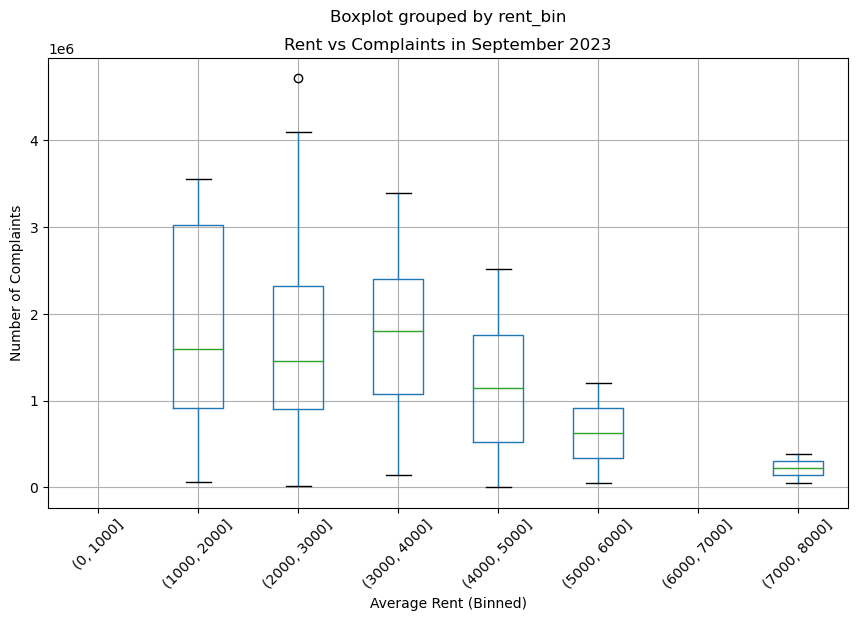

In [70]:
visualize_rent_vs_complaints()

## Visualization 5: Recent 311 Incidents Near a Specific Location

**Objective:** Create a geospatial plot of the coordinates of 311 incidents reported between January 1st, 2023, and September 30th, 2023, within a 1-kilometer radius of a given coordinate point.

**Implementation:** 
1. An SQL query is used to retrieve 311 incident data within the specified timeframe (January to September 2023) and within a 1-kilometer radius of a predefined coordinate point.
2. The data is converted into a GeoDataFrame for geospatial plotting.
3. The resulting plot displays the location of 311 incidents as red markers on a map.
4. The point of interest is defined by the coordinates (latitude: 40.80737875669467, longitude: -73.96253174434912).

**Interpretation:** 
This visualization provides a geospatial representation of 311 incidents reported near a specific location. By plotting the incident coordinates on a map, we can visually assess the distribution and proximity of recent 311 incidents to the given point of interest. This information can help in understanding the localized trends and issues within the immediate area.


In [71]:
def visualize_recent_311_incidents():
    engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")

    # Define the center point and radius (1 km)
    center_point = Point(-73.96253174434912, 40.80737875669467)
    radius = 1000  # in meters

    # SQL query to get 311 incidents within the radius and timeframe
    query = """
    SELECT id, ST_X(geometry) as longitude, ST_Y(geometry) as latitude
    FROM complaints
    WHERE created_date BETWEEN '2023-01-01' AND '2023-09-30'
    AND ST_DWithin(geometry, ST_SetSRID(ST_MakePoint(%s, %s), 4326)::geography, %s)
    """
    
    df = pd.read_sql(query, engine, params=(center_point.x, center_point.y, radius))


    # Convert DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, marker='o', color='red', markersize=5)
    plt.title('Recent 311 Incidents Near a Point')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

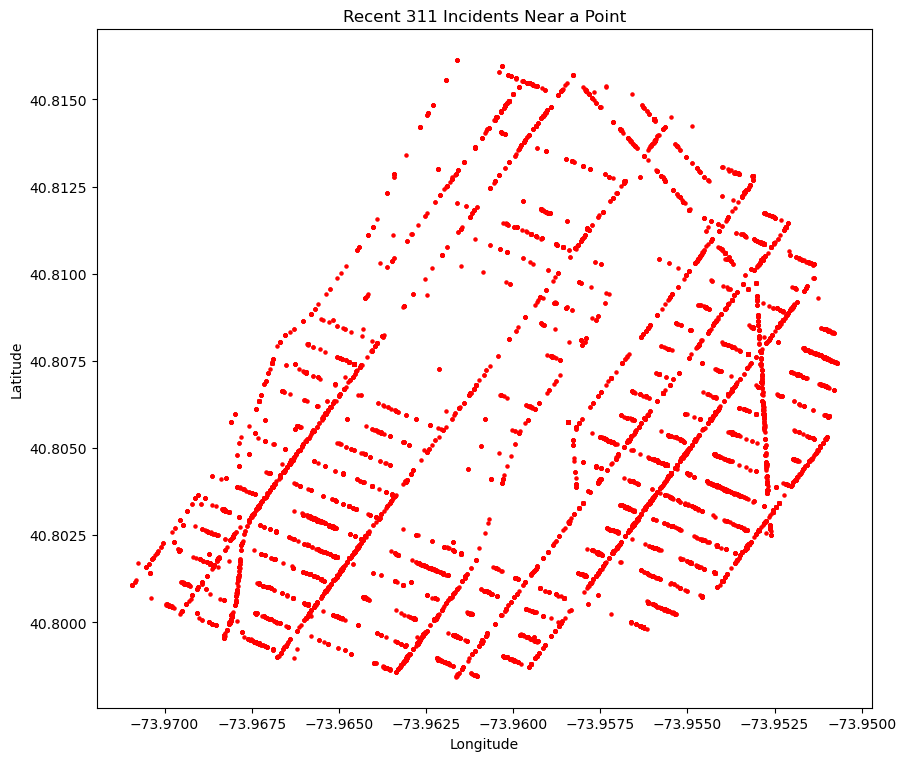

In [72]:
visualize_recent_311_incidents()

## Visualization 6: Trees and New Tree Requests in NYC

**Objective:** Create a geospatial plot that visualizes two sets of data - the coordinates of trees in NYC and the coordinates of "New Tree Request" 311 complaints made between October 1st, 2018, and September 30th, 2023.

**Implementation:** 
1. Two separate SQL queries are used to retrieve data for trees and "New Tree Request" complaints from the database.
2. The data is converted into GeoDataFrames to enable geospatial plotting.
3. The GeoDataFrames are overlaid on a single plot, with trees represented as green markers and new tree requests as blue markers.
4. The resulting plot displays the locations of both trees and new tree requests, allowing for a visual comparison.

**Interpretation:** 
This visualization allows us to explore the relationship between existing trees and the demand for new trees in NYC. By plotting both datasets on a map, we can visually assess areas with a high concentration of existing trees and areas with a significant number of new tree requests. This information can be valuable for urban planning and tree planting initiatives to identify areas where tree planting efforts may be needed.


In [73]:
def visualize_trees_and_new_requests():
    engine = create_engine("postgresql+psycopg2://joyliu@localhost:5432/group19project")

    # SQL query for trees
    trees_query = "SELECT tree_id, ST_X(geometry) as longitude, ST_Y(geometry) as latitude FROM trees"
    trees_df = pd.read_sql(trees_query, engine)

    # SQL query for new tree requests
    requests_query = """
    SELECT id, ST_X(geometry) as longitude, ST_Y(geometry) as latitude
    FROM complaints
    WHERE complaint_type = 'New Tree Request' AND created_date BETWEEN '2018-10-01' AND '2023-09-30'
    """
    requests_df = pd.read_sql(requests_query, engine)

    # Convert to GeoDataFrames
    trees_gdf = gpd.GeoDataFrame(trees_df, geometry=gpd.points_from_xy(trees_df.longitude, trees_df.latitude))
    requests_gdf = gpd.GeoDataFrame(requests_df, geometry=gpd.points_from_xy(requests_df.longitude, requests_df.latitude))

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    trees_gdf.plot(ax=ax, marker='o', color='green', markersize=5, label='Trees')
    requests_gdf.plot(ax=ax, marker='x', color='blue', markersize=5, label='New Tree Requests')
    plt.title('Trees and New Tree Requests in NYC')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

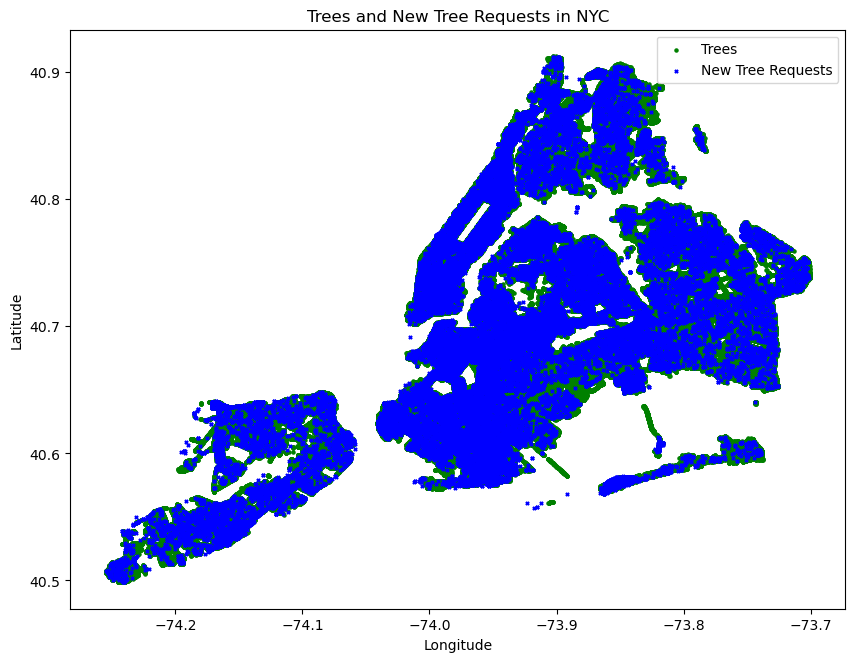

In [74]:
visualize_trees_and_new_requests()